Install Packages

In [ ]:
%pip install lightning
%pip install scikit-build
%pip install opencv-python

Import Packages

In [8]:
import cv2

import matplotlib.pyplot as plt
import os
import numpy as np
import requests
import zipfile
from tqdm import tqdm

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from skimage.feature import hog

Downoad Data

In [3]:
root_dir = ''
print(root_dir)

data_dir = os.path.join(root_dir,"nist_dataset/")
data_resource = "https://s3.amazonaws.com/nist-srd/SD19/by_class.zip"
zip_dir = os.path.join(data_dir, "by_class.zip")
extracted_data_dir = os.path.join(data_dir, "extracted/")

if not os.path.exists(data_dir):
    os.makedirs(data_dir)

    with open(zip_dir, 'wb') as out_file:
        content = requests.get(data_resource, stream=True).content
        out_file.write(content)

    with zipfile.ZipFile(zip_dir, 'r') as zip_ref:
        # Get list of all files in the ZIP
        file_list = zip_ref.namelist()

        # Show progress
        with tqdm(total=len(file_list), desc="Extracting Files", unit="file") as progress_bar:
            for file in file_list:
                zip_ref.extract(file, extracted_data_dir)  # Extract each file
                progress_bar.update(1)
else:
    print(f"Dataset already extracted at {extracted_data_dir}")


Dataset already extracted at nist_dataset/extracted/


Prepare and Load Data Into Memory

In [5]:
# dataset preparation
img_paths, labels = [], []

ascii_folders = os.listdir(os.path.join(extracted_data_dir,"by_class"))
for ascii_num in ascii_folders:
    # Convert folder name from hexadecimal to ASCII
    label = chr(int(ascii_num, 16))
    train_folder = os.path.join(extracted_data_dir,"by_class",f"{ascii_num}",f"train_{ascii_num}")

    if os.path.exists(train_folder):
        # Loop through each file in the train_folder
        for file in os.listdir(train_folder):
            if file.endswith(".png"):
                # Add full path to the list of image paths
                img_paths.append(os.path.join(train_folder, file))
                labels.append(label)

print(f"Total samples: {len(img_paths)}")

# Define the split ratios
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Shuffle Dataset
combined = list(zip(img_paths, labels))
np.random.seed(67) 
np.random.shuffle(combined) 
img_paths, labels = zip(*combined)

# Calculate split indices
total_samples = len(img_paths)
train_end = int(total_samples * train_ratio)
val_end = train_end + int(total_samples * val_ratio)

# Split the dataset
train_img_paths = img_paths[:train_end]
val_img_paths = img_paths[train_end:val_end]
test_img_paths = img_paths[val_end:]

train_labels = labels[:train_end]
val_labels = labels[train_end:val_end]
test_labels = labels[val_end:]

print(f"Training samples: {len(train_img_paths)}")
print(f"Validation samples: {len(val_img_paths)}")
print(f"Test samples: {len(test_img_paths)}")


# define a dataset loader that does the inital transforms
def dataset_loader(image_paths):
    images = []
    with tqdm(total=len(image_paths), desc="Loading Dataset", unit="imaage_path") as progress_bar:
        for ii, (image_path, label) in enumerate(zip(image_paths,labels)):

            image = cv2.imread(os.path.join(image_path))
            image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            resized_image = cv2.resize(image_gray, (32, 32))
            transformed_image = ((resized_image/255) - 0.5) / 0.5
            images.append(transformed_image)
            if ii % 5000 == 0:
                progress_bar.update(5000)
    return images

# load the datasets
train_ds = dataset_loader(train_img_paths, train_labels)
val_ds = dataset_loader(val_img_paths, val_labels)
test_ds = dataset_loader(test_img_paths, test_labels)

Total samples: 731668
Training samples: 585334
Validation samples: 73166
Test samples: 73168


Loading Dataset: 590000imaage_path [24:23, 403.15imaage_path/s]                   
Loading Dataset: 75000imaage_path [03:23, 368.22imaage_path/s]                  
Loading Dataset: 75000imaage_path [03:24, 366.17imaage_path/s]                  


Extract Features for the Training Data Set

In [6]:
def extract_features(image_list):
    hog_features = []
    moment_features = []
    with tqdm(total=len(image_list), desc="Computing Features", unit="images") as progress_bar:
        for ii, image in enumerate(image_list):
           
            # Compute HOG features
            hog_feat = hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys')
            hog_features.append(hog_feat)
            
            # Compute Hu moments
            moments = cv2.moments(image)
            hu_moments = cv2.HuMoments(moments).flatten()
            moment_features.append(hu_moments)
            if ii % 5000 == 0:
                progress_bar.update(5000)
    
    # combine features into list of 1d vectors
    hog_features = np.array(hog_features)
    moment_features = np.array(moment_features)
    combined_features = np.hstack((hog_features, moment_features))
    return combined_features


In [ ]:
train_images = []
for train_entry in train_ds:
    train_images.append(train_entry['image'])

test_images = []
for test_entry in test_ds:
    test_images.append(test_entry['image'])

train_features = extract_features(train_images)

Train the Random Forest and Evaulate on the Test Set

In [10]:
randforest = RandomForestClassifier(n_estimators=100, random_state=67, verbose=5)
randforest.fit(train_features, train_labels)

test_features = extract_features(test_images)



building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:  3.4min


building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59

[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed: 15.5min


building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


Loading Dataset: 75000images [00:19, 3893.19images/s]                       
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    4.1s


Accuracy: 68.20%


Evaulate Performance on the Test Set

In [24]:
test_preds = randforest.predict(test_features)
accuracy = accuracy_score(test_labels, test_preds)
print(f"Accuracy: {accuracy * 100:.2f}%")

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    4.3s


Accuracy: 68.20%


Generate Confusion Matrix and Plot

tensor(0.6820)


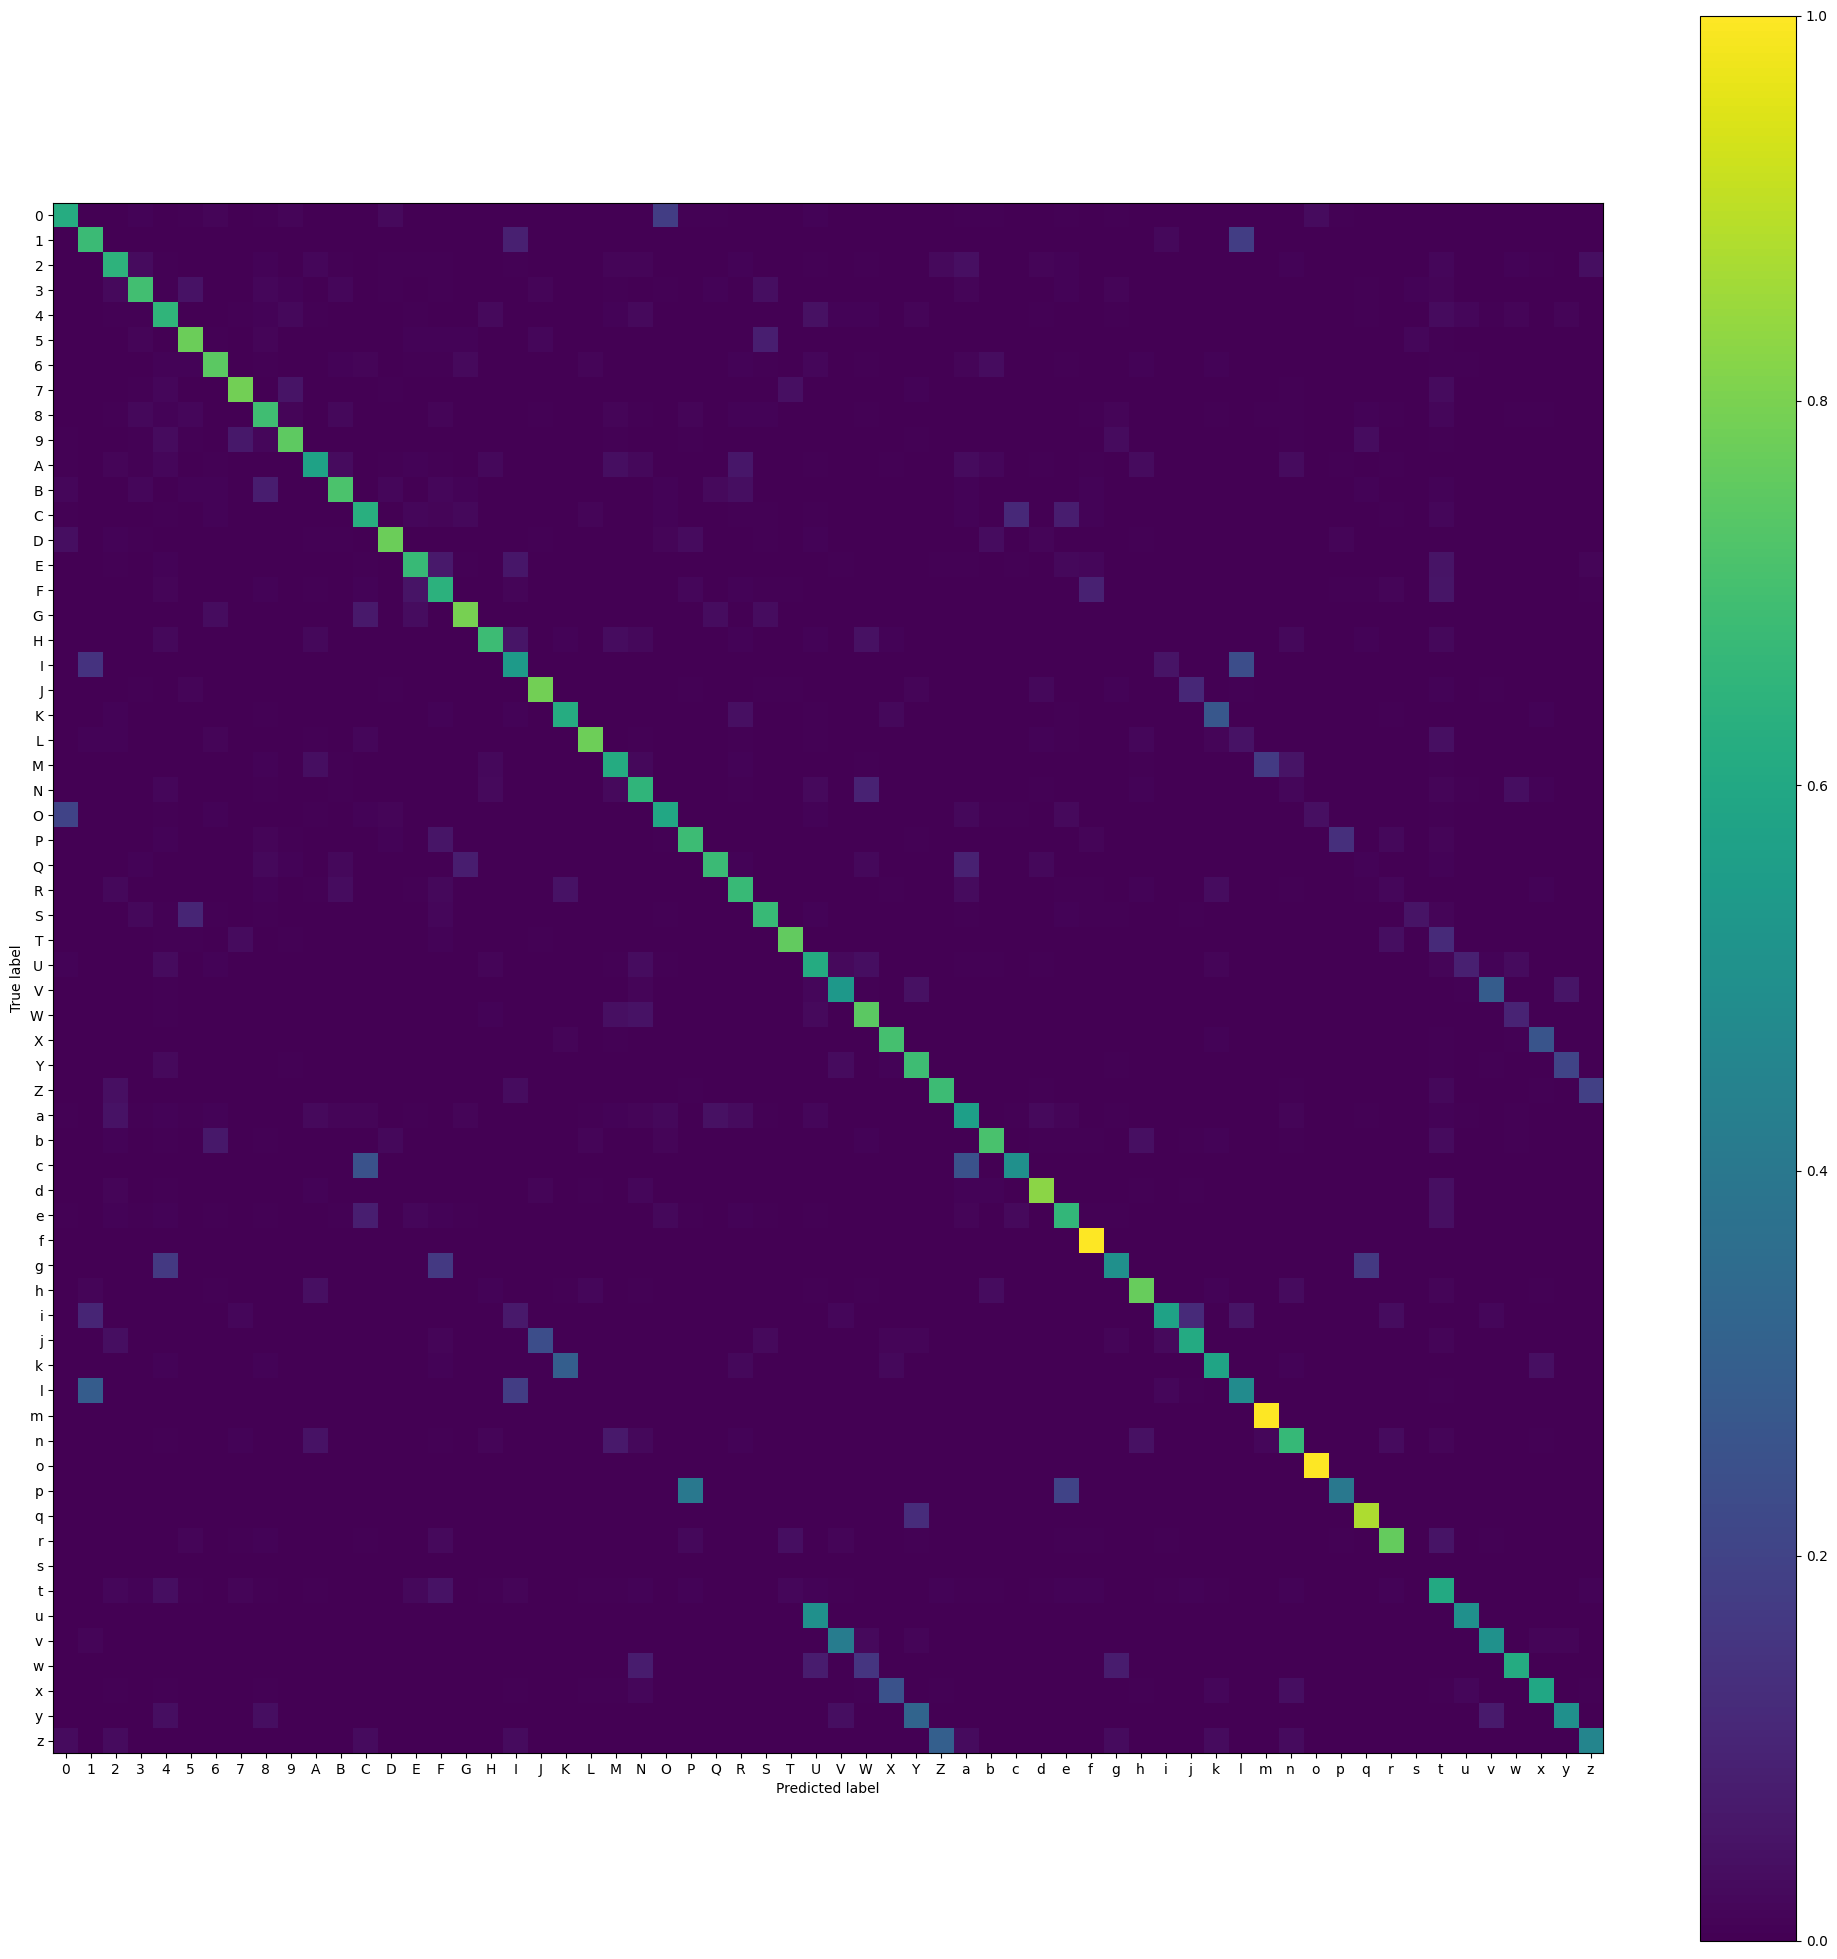

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
from torchmetrics.classification import Accuracy

ascii_folders = os.listdir(os.path.join(extracted_data_dir,"by_class"))
letter_labels = np.asarray([chr(int(ll,16)) for ll in ascii_folders])

# order labels alphabetically
ordered_indices = np.argsort(letter_labels)
letter_labels = letter_labels[ordered_indices]

cm = confusion_matrix(test_preds, test_labels, normalize = "true")
cm = cm[ordered_indices, :]
cm = cm[:, ordered_indices]
fig, ax = plt.subplots(figsize=(25, 25))

ConfusionMatrixDisplay(cm, display_labels = letter_labels).plot(ax = ax, include_values = False)

# convert letters to numerical representations
test_labels_ord = []
for test_label in test_labels:
    test_labels_ord.append(ord(test_label))
test_labels_ord = np.asarray(test_labels_ord)

test_preds_ord = []
for test_pred in test_preds:
    test_preds_ord.append(ord(test_pred))
test_preds_ord = np.asarray(test_preds_ord)

test_accuracy = Accuracy(task="multiclass", num_classes=128)
test_accuracy.update(torch.asarray(test_preds_ord), torch.asarray(test_labels_ord))
t_acc = test_accuracy.compute()
print(t_acc)